In [1]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin  
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import holidays
import os

# Creating the Pre-Processor Pipeline: Initial DataFrame

This Pipeline will have 4 steps:

- ColumnSelector: We select the 'counter_id' and 'date' features
- DateFormatter : Separate the datetime column into separate features.<br> We then drop the original 'date' column
- HolidaysFR: Adding a binary feature for french holiday dates and weekends
- EncodeCounter: OneHotEncoding the 'counter_id' feature and then drop the original column.
- MergeWeather: Merging weather data from Orly and Paris

In [2]:
class ColumnSelector(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[['counter_id','date']]


class DateFormatter(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['date'] = pd.to_datetime(X_copy['date'])
        X_copy['year'] = X_copy['date'].dt.year
        X_copy['month'] = X_copy['date'].dt.month
        #X_copy['week'] = X_copy['date'].dt.isocalendar().week
        X_copy['weekday'] = (X_copy['date'].dt.dayofweek + 1)
        #X_copy['day'] = X_copy['date'].dt.day
        X_copy['hour'] = X_copy['date'].dt.hour
        #X_copy['minute'] = X_copy['date'].dt.minute  # Not relevant
        #X_copy.drop(columns='date', inplace=True)  # Will be dropped later, useful to keep to merge wither other dfs.
        return X_copy


class AddRestrictionLevel(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        
        # Define date ranges and corresponding restriction levels
        date_ranges = [
            ('16/10/2020', '17/10/2020'),
            ('17/10/2020', '28/11/2020'),
            ('28/11/2020', '15/12/2020'),
            ('15/12/2020', '16/01/2021'),
            ('16/01/2021', '19/03/2021'),
            ('19/03/2021', '03/05/2021'),
            ('03/05/2021', '09/06/2021'),
            ('09/06/2021', '20/06/2021'),
            ('20/06/2021', '30/06/2021')
        ]
        
        restriction_levels = [3, 5, 4, 2, 1, 5, 4, 2, 1, 0]

        # Convert date strings to datetime objects
        date_ranges = [(pd.to_datetime(start, dayfirst=True), pd.to_datetime(end, dayfirst=True)) for start, end in date_ranges]

        # Add restriction_level column based on date ranges
        X_copy['restriction_level'] = 0  # Default value
        for level, (start_date, end_date) in zip(restriction_levels, date_ranges):
            mask = (X_copy['date'] >= start_date) & (X_copy['date'] < end_date)
            X_copy.loc[mask, 'restriction_level'] = level

        return X_copy


class HolidaysFR(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        is_holiday = lambda date: 1 if date in holidays.FR() else 0
        is_weekend = lambda day: 1 if day in (6,7) else 0
        X_copy = X.copy()
        X_copy['is_Holiday'] = X_copy['date'].apply(is_holiday)
        X_copy['is_Weekend'] = X_copy['weekday'].apply(is_weekend)
        #X_copy.drop(columns='date', inplace=True)
        return X_copy


class EncodeCounter(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy = pd.get_dummies(X_copy, columns=['counter_id'], dtype=int, drop_first=True)
        return X_copy


class MergeWeatherCovid(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        data = pd.read_csv(os.path.join("..", "Datasets", "weather_data_cleaned.csv"))
        data['date'] = pd.to_datetime(data['date']).astype('datetime64[us]')
        merged_data = pd.merge_asof(X, data, on='date')
        #merged_data.drop(columns='date', inplace=True)
        return merged_data

class MergeMultimodal(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        # Import Multimodal Data
        mult_df = pd.read_csv(os.path.join("..", "Datasets", "multimodal_data.csv"))
        mult_df['date'] = pd.to_datetime(mult_df['date']).astype('datetime64[us]')
        # Averaging and scaling the count
        mult_df = pd.DataFrame(mult_df.groupby(['date'])['count'].sum()).reset_index()
        scaler = StandardScaler()
        numerical_columns = mult_df.select_dtypes(include='number').columns
        mult_df[numerical_columns] = scaler.fit_transform(mult_df[numerical_columns])
        # Merging data
        merged_data = pd.merge_asof(X_copy, mult_df, on='date')
        merged_data.rename(columns={'count': 'average_multimodal_count'})
        merged_data.drop(columns='date', inplace=True)
        return merged_data


preprocess = Pipeline([
    ("ColumnSelector", ColumnSelector()),
    ("DateFormatter", DateFormatter()),
    ("AddRestrictionLevel", AddRestrictionLevel()),
    ("HolidaysFR", HolidaysFR()),
    ("EncodeCounter", EncodeCounter()),
    ("MergeWeatherCovid", MergeWeatherCovid()),
    ("MergeMultimodal", MergeMultimodal())
])        


We now import and process the dataset.<br>Note: We sort the data by date before separating the target variable. This is required to merge the weather data using pd.merge.asof() to the nearest datetime value later on

In [3]:
import os

df = pd.read_parquet(os.path.join("..", "Datasets", "train.parquet"))
df = df.sort_values('date') # Sort by date 

In [4]:
X = preprocess.fit_transform(df)
y = df['log_bike_count']

## This is our regression model

In [8]:
# # Import necessary libraries
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error
# #from sklearn.model_selection import cross_val_score

# # Setting seed
# np.random.seed(42)

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Initialize the Linear Regression model
# model = LinearRegression()

# # Fit the model on the training data
# model.fit(X_train, y_train)

# # Make predictions on the test set
# y_pred = model.predict(X_test)

# # Evaluate the model
# rmse = mean_squared_error(y_test, y_pred, squared=False)

# # Print the model coefficients and evaluation metrics
# #print("Coefficients:", model.coef_)
# #print("Intercept:", model.intercept_)
# print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 1.2120347921806025


#### Fitting regression on the entire dataset

In [ ]:
# # Fit on the full train set:
# X = preprocess.fit_transform(df)
# y = df['log_bike_count']

# # Initialize the Linear Regression model
# model = LinearRegression()

# # Fit the model on the training data
# model.fit(X,y)

# Import test set
df_test = pd.read_parquet(os.path.join("..", "Datasets", "final_test.parquet"))
df_test = df_test.sort_values('date') # Sort by date 
new_order = df_test.index.tolist() #Keep index order


df_test = preprocess.transform(df_test)
predictions = model.predict(df_test)
predictions_df = pd.DataFrame({'Id': new_order, 'log_bike_count': predictions})
predictions_df = predictions_df.sort_values('Id')

# Specify the file path
csv_file_path = 'submission.csv'

# Write the DataFrame to a CSV file
predictions_df.to_csv(csv_file_path, index=False)

## We'll try a random forest regression

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
#from sklearn.model_selection import cross_val_score

# Setting seed
np.random.seed(42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Linear Regression model
model = RandomForestRegressor()

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Print the model coefficients and evaluation metrics
#print("Coefficients:", model.coef_)
#print("Intercept:", model.intercept_)
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 0.4178446638566196


In [13]:
total_samples = len(X)
split_index = int(0.8 * total_samples)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

model = RandomForestRegressor()

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

predictions_df = pd.DataFrame({'Id': new_order, 'log_bike_count': predictions})
predictions_df = predictions_df.sort_values('Id')



In [35]:

new_order = X_test.index.tolist() #Keep index order
predictions_df = pd.DataFrame({'Id': new_order, 'true_value': y_test, 'log_bike_count_predicted': y_pred})
df.reset_index(drop=True, inplace=True)
predictions_df = predictions_df.sort_values('Id')
predictions_df.set_index('Id', inplace=True)
predictions_df.reset_index(drop=True, inplace=True)

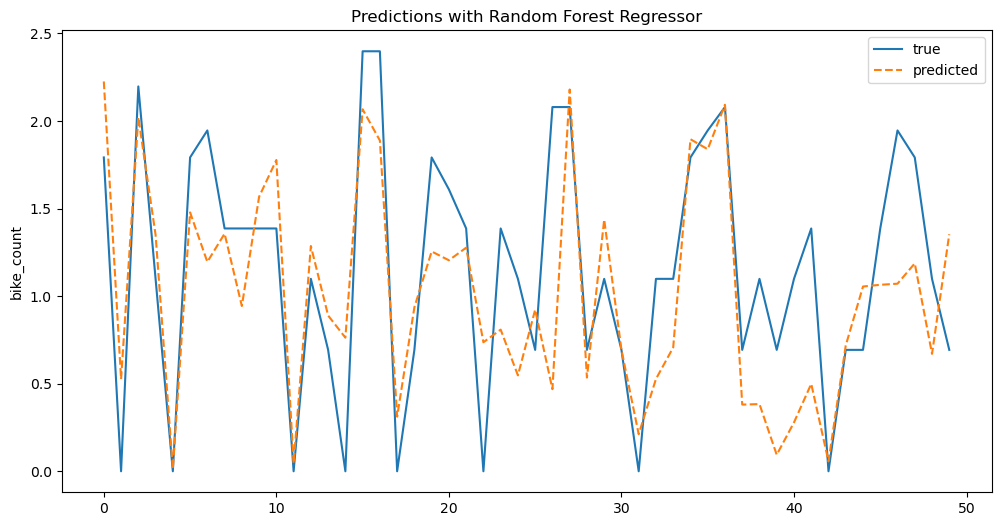

In [48]:
# let's look at how our models is performing 
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))


plt.plot(predictions_df['true_value'][:50], label='true')
plt.plot(predictions_df['log_bike_count_predicted'][:50], ls="--", label='predicted')
plt.title("Predictions with Random Forest Regressor")
plt.ylabel("bike_count")
plt.legend()
plt.show()

# Now, let us train on the entire training set, and predict on the test set

We output to csv. To output on Kaggle use estimator.py script

In [49]:
# # Fit on the full train set:
X = preprocess.fit_transform(df)
#y = df['log_bike_count']

# # Initialize the Linear Regression model
#model = RandomForestRegressor()

# # Fit the model on the training data
#model.fit(X,y)

# Import test set
df_test = pd.read_parquet(os.path.join("..", "Datasets", "final_test.parquet"))
df_test = df_test.sort_values('date') # Sort by date 
new_order = df_test.index.tolist() #Keep index order


df_test = preprocess.transform(df_test)
predictions = model.predict(df_test)
predictions_df = pd.DataFrame({'Id': new_order, 'log_bike_count': predictions})
predictions_df = predictions_df.sort_values('Id')

# Specify the file path
csv_file_path = 'submission2.csv'

# Write the DataFrame to a CSV file
predictions_df.to_csv(csv_file_path, index=False)


KeyboardInterrupt: 

In [16]:
import xgboost as xgb
X = preprocess.fit_transform(df)
y = df['log_bike_count']

dtrain = xgb.DMatrix(X, label=y)

params = {'objective': 'reg:squarederror', 'n_estimators': 100, 'random_state': 84}

xgb_model = xgb.train(params, dtrain)

df_test = preprocess.transform(df_test)
predictions = xgb_model.predict(df_test)

predictions_df = pd.DataFrame({'Id': new_order, 'log_bike_count': predictions})
predictions_df = predictions_df.sort_values('Id')

# Specify the file path
csv_file_path = 'submissionXG.csv'

predictions_df.to_csv(csv_file_path, index=False)


c:\Users\35387\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [21:47:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


KeyError: "None of [Index(['counter_id', 'date'], dtype='object')] are in the [columns]"

In [ ]:
df_test = pd.read_parquet(os.path.join("..", "Datasets", "final_test.parquet"))

In [ ]:
df = pd.read_parquet(os.path.join("..", "Datasets", "train.parquet"))


In [ ]:
counts = df_test['site_name'].value_counts()


In [ ]:
import matplotlib.pyplot as pt

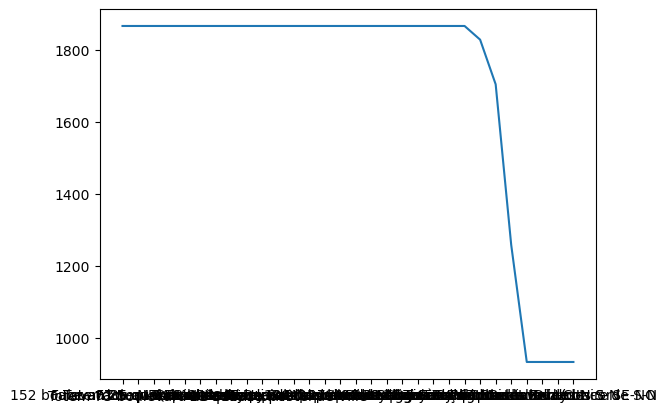

In [ ]:
pt.plot(counts)

In [ ]:
filtered_1800 = counts[counts <= 1800].index

In [ ]:
filtered_mainframe = df[df['site_name'].isin(filtered_1800)]


In [ ]:
filtered_mainframe

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2.302585
...,...,...,...,...,...,...,...,...,...,...,...,...
815206,100057380-103057380,Totem Cours la Reine O-E,100057380,Totem Cours la Reine,175.0,2021-09-09 12:00:00,2020-02-11,"48.86462,2.31444",YTH19111509,48.864620,2.314440,5.170484
815209,100057380-103057380,Totem Cours la Reine O-E,100057380,Totem Cours la Reine,544.0,2021-09-09 16:00:00,2020-02-11,"48.86462,2.31444",YTH19111509,48.864620,2.314440,6.300786
815212,100057380-103057380,Totem Cours la Reine O-E,100057380,Totem Cours la Reine,91.0,2021-09-09 20:00:00,2020-02-11,"48.86462,2.31444",YTH19111509,48.864620,2.314440,4.521789
815215,100057380-103057380,Totem Cours la Reine O-E,100057380,Totem Cours la Reine,82.0,2021-09-09 22:00:00,2020-02-11,"48.86462,2.31444",YTH19111509,48.864620,2.314440,4.418841


In [ ]:
import folium

m = folium.Map(location=filtered_mainframe[["latitude", "longitude"]].mean(axis=0), zoom_start=13)

for _, row in (
    filtered_mainframe[["counter_name", "latitude", "longitude"]]
    .drop_duplicates("counter_name")
    .iterrows()
):
    folium.Marker(
        row[["latitude", "longitude"]].values.tolist(), popup=row["counter_name"]
    ).add_to(m)

m